## Setup

## 1. Setup

In [ ]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import rasterio

# Add project to path
PROJECT_ROOT = Path.cwd().parent
if not (PROJECT_ROOT / 'src').exists():
    PROJECT_ROOT = Path(r'c:\TEMP_1\satellite_git_vt\satellite_git')
sys.path.insert(0, str(PROJECT_ROOT / 'src'))

from satellite_analysis.utils import AreaSelector
from satellite_analysis.analyzers.classification import ConsensusClassifier

print(f"✅ Ready! Project: {PROJECT_ROOT.name}")

## 2. Select City

Change the city name below. Available: Milan, Rome, Florence, Venice, Turin, Naples, Bologna.

In [ ]:
# ===== CHANGE THIS =====
CITY = "Milan"
RADIUS_KM = 15
# =======================

selector = AreaSelector()
bbox, info = selector.select_by_city(CITY, radius_km=RADIUS_KM)

print(f"🌍 {CITY}")
print(f"📍 {info['center'][0]:.3f}°N, {info['center'][1]:.3f}°E")
print(f"📐 {RADIUS_KM} km radius")

## 3. Load Satellite Data

In [ ]:
# Find data
city_key = CITY.lower().replace(' ', '_')
data_paths = [
    PROJECT_ROOT / f"data/cities/{city_key}/bands",
    PROJECT_ROOT / f"data/cities/{city_key}",
    PROJECT_ROOT / f"data/processed/{city_key}_centro",
    PROJECT_ROOT / "data/processed/milano_centro",  # fallback
]

DATA_DIR = None
for p in data_paths:
    if p.exists() and (p / "B02.tif").exists():
        DATA_DIR = p
        break

if DATA_DIR is None:
    print("❌ No data found!")
    print(f"\n👉 Run this in terminal first:")
    print(f"   python scripts/analyze_city.py --city {CITY}")
else:
    print(f"✅ Data: {DATA_DIR}")
    
    # Load bands
    bands = {}
    for name in ['B02', 'B03', 'B04', 'B08']:
        with rasterio.open(DATA_DIR / f"{name}.tif") as src:
            bands[name] = src.read(1)
    
    stack = np.stack([bands['B02'], bands['B03'], bands['B04'], bands['B08']], axis=-1)
    print(f"📊 Shape: {stack.shape} ({stack.shape[0]*stack.shape[1]:,} pixels)")

## 4. RGB Preview

Check that we have the correct area.

In [ ]:
if DATA_DIR:
    # Create RGB (B04=Red, B03=Green, B02=Blue)
    rgb = np.stack([bands['B04'], bands['B03'], bands['B02']], axis=-1).astype(np.float32)
    
    # Normalize for display
    p2, p98 = np.percentile(rgb, [2, 98])
    rgb = np.clip((rgb - p2) / (p98 - p2), 0, 1)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(rgb)
    plt.title(f'{CITY} - Satellite View', fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

## 5. Run Classification

Using **Consensus Classifier** (K-Means + Spectral combined).

**Classes:**
- 0: Water 🌊
- 1: Vegetation 🌲
- 2: Bare Soil 🏜️
- 3: Urban 🏙️
- 4: Bright Surfaces ☀️
- 5: Shadows/Mixed 🌑

In [ ]:
if DATA_DIR:
    print("🔄 Running classification...")
    
    classifier = ConsensusClassifier(n_clusters=6)
    labels, confidence, uncertainty, stats = classifier.classify(
        stack, 
        band_indices={'B02': 0, 'B03': 1, 'B04': 2, 'B08': 3}
    )
    
    print(f"✅ Done!")
    print(f"📊 Agreement: {stats['agreement']:.1%}")
    print(f"📊 Avg Confidence: {stats['average_confidence']:.2f}")
    print(f"📊 Uncertain Pixels: {stats['uncertain_pixels']:.1%}")

## 6. Results

In [ ]:
if DATA_DIR:
    from matplotlib.colors import ListedColormap
    from matplotlib.patches import Patch
    
    # Colors and names
    colors = ['#0066CC', '#228B22', '#CD853F', '#808080', '#FFD700', '#2F2F2F']
    names = ['Water', 'Vegetation', 'Bare Soil', 'Urban', 'Bright', 'Shadow']
    cmap = ListedColormap(colors)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # RGB
    axes[0].imshow(rgb)
    axes[0].set_title('Satellite Image')
    axes[0].axis('off')
    
    # Classification
    im = axes[1].imshow(labels, cmap=cmap, vmin=0, vmax=5)
    axes[1].set_title('Land Cover Classification')
    axes[1].axis('off')
    
    # Confidence
    conf_im = axes[2].imshow(confidence, cmap='RdYlGn', vmin=0, vmax=1)
    axes[2].set_title('Confidence Map')
    axes[2].axis('off')
    plt.colorbar(conf_im, ax=axes[2], fraction=0.046)
    
    # Legend
    legend = [Patch(color=c, label=n) for c, n in zip(colors, names)]
    fig.legend(handles=legend, loc='lower center', ncol=6, fontsize=10)
    
    plt.suptitle(f'{CITY} - Land Cover Analysis', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

## 7. Class Distribution

In [ ]:
if DATA_DIR:
    print(f"\n📊 {CITY} - Land Cover Distribution\n")
    print(f"{'Class':<15} {'Pixels':>12} {'%':>8}")
    print("-" * 37)
    
    total = labels.size
    for i, name in enumerate(names):
        count = np.sum(labels == i)
        pct = count / total * 100
        bar = '█' * int(pct / 2)
        print(f"{name:<15} {count:>12,} {pct:>7.1f}% {bar}")

## 8. Save Results

In [ ]:
if DATA_DIR:
    output_dir = PROJECT_ROOT / f"data/cities/{city_key}/notebook_output"
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Save arrays
    np.save(output_dir / 'labels.npy', labels)
    np.save(output_dir / 'confidence.npy', confidence)
    
    # Save figure
    fig.savefig(output_dir / 'analysis.png', dpi=150, bbox_inches='tight')
    
    print(f"✅ Saved to: {output_dir}")

---

## Next Steps

- **Try another city**: Change `CITY` in cell 2
- **Validate results**: `python scripts/validate_classification.py --city Milan`
- **Web UI**: `streamlit run scripts/app.py`

## Setup

In [ ]:
import sys
import os

# Ensure we can import from src
notebook_dir = os.path.dirname(os.path.abspath('__file__'))
project_root = os.path.dirname(notebook_dir) if notebook_dir.endswith('notebooks') else notebook_dir
# Fallback: use known project path
if not os.path.exists(os.path.join(project_root, 'src')):
    project_root = r'c:\TEMP_1\satellite_git_vt\satellite_git'

sys.path.insert(0, os.path.join(project_root, 'src'))

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import rasterio

# Our modules
from satellite_analysis.utils import AreaSelector
from satellite_analysis.analyzers.classification import ConsensusClassifier
from satellite_analysis.preprocessing.normalization import min_max_scale

PROJECT_ROOT = Path(project_root)
print(f"✅ Setup complete!")
print(f"   Project: {PROJECT_ROOT}")

## Step 1: Select City

Choose a city to analyze. The system will find its coordinates automatically.

In [ ]:
# ========================================
# 👇 CHANGE THIS TO YOUR CITY
# ========================================
CITY = "Milan"
RADIUS_KM = 15
# ========================================

selector = AreaSelector()
bbox, info = selector.select_by_city(CITY, radius_km=RADIUS_KM)

print(f"🌍 City: {CITY}")
print(f"📍 Center: {info['center'][0]:.4f}°N, {info['center'][1]:.4f}°E")
print(f"📐 Radius: {RADIUS_KM} km")
print(f"📦 Bounding Box: {bbox}")

## Step 2: Load Satellite Data

Load the Sentinel-2 bands (B02=Blue, B03=Green, B04=Red, B08=NIR).

**Note:** You need to have the data downloaded first. If not available, see the "Data Download" section at the end.

In [ ]:
# Find data directory
city_key = CITY.lower().replace(' ', '_')

possible_dirs = [
    PROJECT_ROOT / f"data/cities/{city_key}/bands",
    PROJECT_ROOT / f"data/cities/{city_key}",
    PROJECT_ROOT / f"data/processed/{city_key}_centro",
    PROJECT_ROOT / f"data/processed/{city_key}",
    # Specific fallback for Milan
    PROJECT_ROOT / "data/processed/milano_centro",
]

data_dir = None
for d in possible_dirs:
    if d.exists() and (d / "B02.tif").exists():
        data_dir = d
        break

if data_dir is None:
    print("❌ No data found!")
    print("\n📥 To download data, run in terminal:")
    print(f"   python scripts/analyze_city.py --city {CITY} --method consensus")
else:
    print(f"✅ Found data in: {data_dir}")

In [ ]:
# Load bands
if data_dir is not None:
    bands = {}
    for band_name in ['B02', 'B03', 'B04', 'B08']:
        with rasterio.open(data_dir / f"{band_name}.tif") as src:
            bands[band_name] = src.read(1)
            print(f"✅ {band_name}: {bands[band_name].shape}")

    # Stack into array (H, W, 4)
    stack = np.stack([bands['B02'], bands['B03'], bands['B04'], bands['B08']], axis=-1)
    print(f"\n📊 Total: {stack.shape[0]:,} × {stack.shape[1]:,} pixels = {stack.shape[0]*stack.shape[1]:,} pixels")
else:
    print("⚠️ Cannot load bands - no data directory found")

## Step 3: Preview Image

Create an RGB preview to verify we have the right area.

In [ ]:
# Create RGB (Red=B04, Green=B03, Blue=B02)
rgb = stack[:, :, [2, 1, 0]].astype(np.float32)

# Normalize each channel
for i in range(3):
    channel = rgb[:, :, i]
    rgb[:, :, i] = (channel - channel.min()) / (channel.max() - channel.min() + 1e-10)

# Apply simple contrast enhancement
rgb = np.clip(rgb * 1.5, 0, 1)

plt.figure(figsize=(12, 10))
plt.imshow(rgb)
plt.title(f"{CITY} - RGB True Color", fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

print("👆 Verify this shows your city area correctly!")

## Step 4: Run Classification

Run the **Consensus Classifier** which combines:
- K-Means clustering (unsupervised)
- Spectral indices (rule-based)

This gives better results than either method alone.

In [ ]:
# Initialize classifier
classifier = ConsensusClassifier(
    n_clusters=6,
    confidence_threshold=0.5,
    random_state=42
)

# Band indices mapping
band_indices = {'B02': 0, 'B03': 1, 'B04': 2, 'B08': 3}

print("🔄 Running classification... (this takes ~30-60 seconds)")

# Run classification
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    labels, confidence, uncertainty, stats = classifier.classify(stack, band_indices)

print("\n✅ Classification complete!")
print(f"\n📊 Results:")
print(f"   Agreement: {stats['agreement_pct']:.1f}%")
print(f"   Confidence: {stats['avg_confidence']:.2f}")
print(f"   Uncertain: {stats['uncertain_pct']:.1f}%")

## Step 5: View Results

In [ ]:
# Class definitions
class_names = {
    0: 'Water',
    1: 'Vegetation', 
    2: 'Bare Soil',
    3: 'Urban',
    4: 'Bright Surfaces',
    5: 'Shadows/Mixed'
}

class_colors = [
    '#0066CC',  # Water - Blue
    '#228B22',  # Vegetation - Green
    '#CD853F',  # Bare Soil - Brown
    '#808080',  # Urban - Gray
    '#FFD700',  # Bright - Yellow
    '#2F2F2F'   # Shadows - Dark
]

# Print class distribution
print("📊 Land Cover Distribution:")
print("-" * 35)
for cls_name, info in stats['class_distribution'].items():
    bar = '█' * int(info['percentage'] / 2)
    print(f"{cls_name:<15} {info['percentage']:>5.1f}% {bar}")

In [ ]:
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# Create figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. RGB
axes[0].imshow(rgb)
axes[0].set_title('RGB True Color', fontsize=12, fontweight='bold')
axes[0].axis('off')

# 2. Classification
cmap = ListedColormap(class_colors)
axes[1].imshow(labels, cmap=cmap, vmin=0, vmax=5)
axes[1].set_title('Land Cover Classification', fontsize=12, fontweight='bold')
axes[1].axis('off')

# 3. Confidence
im = axes[2].imshow(confidence, cmap='RdYlGn', vmin=0, vmax=1)
axes[2].set_title('Confidence Map', fontsize=12, fontweight='bold')
axes[2].axis('off')
plt.colorbar(im, ax=axes[2], fraction=0.046)

# Legend
legend_elements = [Patch(facecolor=class_colors[i], label=class_names[i]) for i in range(6)]
fig.legend(handles=legend_elements, loc='lower center', ncol=6, fontsize=10, 
           bbox_to_anchor=(0.5, -0.02))

plt.suptitle(f'{CITY} - Satellite Analysis Results', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Step 6: Save Results (Optional)

In [ ]:
# Save outputs
output_dir = data_dir.parent / "notebook_results"
output_dir.mkdir(exist_ok=True)

# Save classification image
fig, ax = plt.subplots(figsize=(12, 10))
ax.imshow(labels, cmap=cmap, vmin=0, vmax=5)
ax.axis('off')
legend_elements = [Patch(facecolor=class_colors[i], label=class_names[i]) for i in range(6)]
ax.legend(handles=legend_elements, loc='upper right', fontsize=9)
plt.savefig(output_dir / 'classification.png', dpi=150, bbox_inches='tight')
plt.close()

# Save labels as numpy array
np.save(output_dir / 'labels.npy', labels)
np.save(output_dir / 'confidence.npy', confidence)

print(f"✅ Results saved to: {output_dir}")
print(f"   - classification.png")
print(f"   - labels.npy")
print(f"   - confidence.npy")

---

## 📥 Data Download Instructions

If you don't have satellite data yet:

### Option 1: Use the CLI script
```bash
python scripts/analyze_city.py --city Milan --method consensus
```

### Option 2: Manual download
1. Go to [Copernicus Browser](https://browser.dataspace.copernicus.eu/)
2. Search for Sentinel-2 L2A products over your city
3. Download a cloud-free image
4. Extract bands using:
   ```bash
   python scripts/extract_all_bands.py <downloaded.zip> data/cities/<city>/bands
   ```

---

**That's it!** 🎉

## Setup

In [10]:
import sys
import os

# Ensure we can import from src
notebook_dir = os.path.dirname(os.path.abspath('__file__'))
project_root = os.path.dirname(notebook_dir) if notebook_dir.endswith('notebooks') else notebook_dir
# Fallback: use known project path
if not os.path.exists(os.path.join(project_root, 'src')):
    project_root = r'c:\TEMP_1\satellite_git_vt\satellite_git'

sys.path.insert(0, os.path.join(project_root, 'src'))

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import rasterio

# Our modules
from satellite_analysis.utils import AreaSelector
from satellite_analysis.analyzers.classification import ConsensusClassifier
from satellite_analysis.preprocessing.normalization import min_max_scale

PROJECT_ROOT = Path(project_root)
print(f"✅ Setup complete!")
print(f"   Project: {PROJECT_ROOT}")

✅ Setup complete!
   Project: c:\TEMP_1\satellite_git_vt\satellite_git


## Step 1: Select City

Choose a city to analyze. The system will find its coordinates automatically.

In [11]:
# ========================================
# 👇 CHANGE THIS TO YOUR CITY
# ========================================
CITY = "Milan"
RADIUS_KM = 15
# ========================================

selector = AreaSelector()
bbox, info = selector.select_by_city(CITY, radius_km=RADIUS_KM)

print(f"🌍 City: {CITY}")
print(f"📍 Center: {info['center'][0]:.4f}°N, {info['center'][1]:.4f}°E")
print(f"📐 Radius: {RADIUS_KM} km")
print(f"📦 Bounding Box: {bbox}")

🌍 City: Milan
📍 Center: 45.4640°N, 9.1900°E
📐 Radius: 15 km
📦 Bounding Box: [8.998203775377618, 45.3290345157878, 9.38179622462238, 45.598962281366084]


## Step 2: Load Satellite Data

Load the Sentinel-2 bands (B02=Blue, B03=Green, B04=Red, B08=NIR).

**Note:** You need to have the data downloaded first. If not available, see the "Data Download" section at the end.

In [12]:
# Find data directory
city_key = CITY.lower().replace(' ', '_')

possible_dirs = [
    PROJECT_ROOT / f"data/cities/{city_key}/bands",
    PROJECT_ROOT / f"data/cities/{city_key}",
    PROJECT_ROOT / f"data/processed/{city_key}_centro",
    PROJECT_ROOT / f"data/processed/{city_key}",
    # Specific fallback for Milan
    PROJECT_ROOT / "data/processed/milano_centro",
]

data_dir = None
for d in possible_dirs:
    if d.exists() and (d / "B02.tif").exists():
        data_dir = d
        break

if data_dir is None:
    print("❌ No data found!")
    print("\n📥 To download data, run in terminal:")
    print(f"   python scripts/analyze_city.py --city {CITY} --method consensus")
else:
    print(f"✅ Found data in: {data_dir}")

✅ Found data in: c:\TEMP_1\satellite_git_vt\satellite_git\data\processed\milano_centro


In [13]:
# Load bands
if data_dir is not None:
    bands = {}
    for band_name in ['B02', 'B03', 'B04', 'B08']:
        with rasterio.open(data_dir / f"{band_name}.tif") as src:
            bands[band_name] = src.read(1)
            print(f"✅ {band_name}: {bands[band_name].shape}")

    # Stack into array (H, W, 4)
    stack = np.stack([bands['B02'], bands['B03'], bands['B04'], bands['B08']], axis=-1)
    print(f"\n📊 Total: {stack.shape[0]:,} × {stack.shape[1]:,} pixels = {stack.shape[0]*stack.shape[1]:,} pixels")
else:
    print("⚠️ Cannot load bands - no data directory found")

✅ B02: (3006, 2980)
✅ B03: (3006, 2980)
✅ B04: (3006, 2980)
✅ B08: (3006, 2980)

📊 Total: 3,006 × 2,980 pixels = 8,957,880 pixels


## Step 3: Preview Image

Create an RGB preview to verify we have the right area.

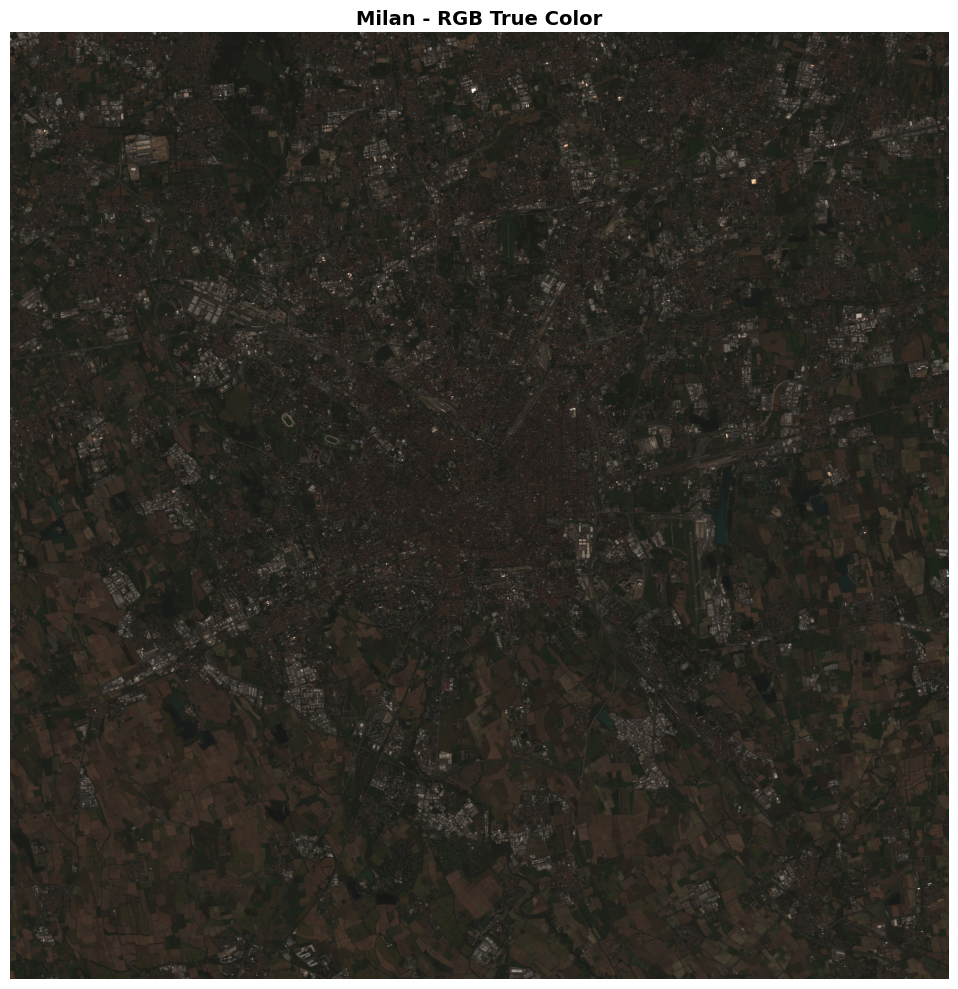

👆 Verify this shows your city area correctly!


In [14]:
# Create RGB (Red=B04, Green=B03, Blue=B02)
rgb = stack[:, :, [2, 1, 0]].astype(np.float32)

# Normalize each channel
for i in range(3):
    channel = rgb[:, :, i]
    rgb[:, :, i] = (channel - channel.min()) / (channel.max() - channel.min() + 1e-10)

# Apply simple contrast enhancement
rgb = np.clip(rgb * 1.5, 0, 1)

plt.figure(figsize=(12, 10))
plt.imshow(rgb)
plt.title(f"{CITY} - RGB True Color", fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

print("👆 Verify this shows your city area correctly!")

## Step 4: Run Classification

Run the **Consensus Classifier** which combines:
- K-Means clustering (unsupervised)
- Spectral indices (rule-based)

This gives better results than either method alone.

In [15]:
# Initialize classifier
classifier = ConsensusClassifier(
    n_clusters=6,
    confidence_threshold=0.5,
    random_state=42
)

# Band indices mapping
band_indices = {'B02': 0, 'B03': 1, 'B04': 2, 'B08': 3}

print("🔄 Running classification... (this takes ~30-60 seconds)")

# Run classification
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    labels, confidence, uncertainty, stats = classifier.classify(stack, band_indices)

print("\n✅ Classification complete!")
print(f"\n📊 Results:")
print(f"   Agreement: {stats['agreement_pct']:.1f}%")
print(f"   Confidence: {stats['avg_confidence']:.2f}")
print(f"   Uncertain: {stats['uncertain_pct']:.1f}%")

🔄 Running classification... (this takes ~30-60 seconds)

✅ Classification complete!

📊 Results:
   Agreement: 57.3%
   Confidence: 0.63
   Uncertain: 31.9%


## Step 5: View Results

In [16]:
# Class definitions
class_names = {
    0: 'Water',
    1: 'Vegetation', 
    2: 'Bare Soil',
    3: 'Urban',
    4: 'Bright Surfaces',
    5: 'Shadows/Mixed'
}

class_colors = [
    '#0066CC',  # Water - Blue
    '#228B22',  # Vegetation - Green
    '#CD853F',  # Bare Soil - Brown
    '#808080',  # Urban - Gray
    '#FFD700',  # Bright - Yellow
    '#2F2F2F'   # Shadows - Dark
]

# Print class distribution
print("📊 Land Cover Distribution:")
print("-" * 35)
for cls_name, info in stats['class_distribution'].items():
    bar = '█' * int(info['percentage'] / 2)
    print(f"{cls_name:<15} {info['percentage']:>5.1f}% {bar}")

📊 Land Cover Distribution:
-----------------------------------
WATER             0.0% 
VEGETATION       57.3% ████████████████████████████
BARE_SOIL        10.7% █████
URBAN             8.8% ████
SHADOWS_MIXED    23.1% ███████████


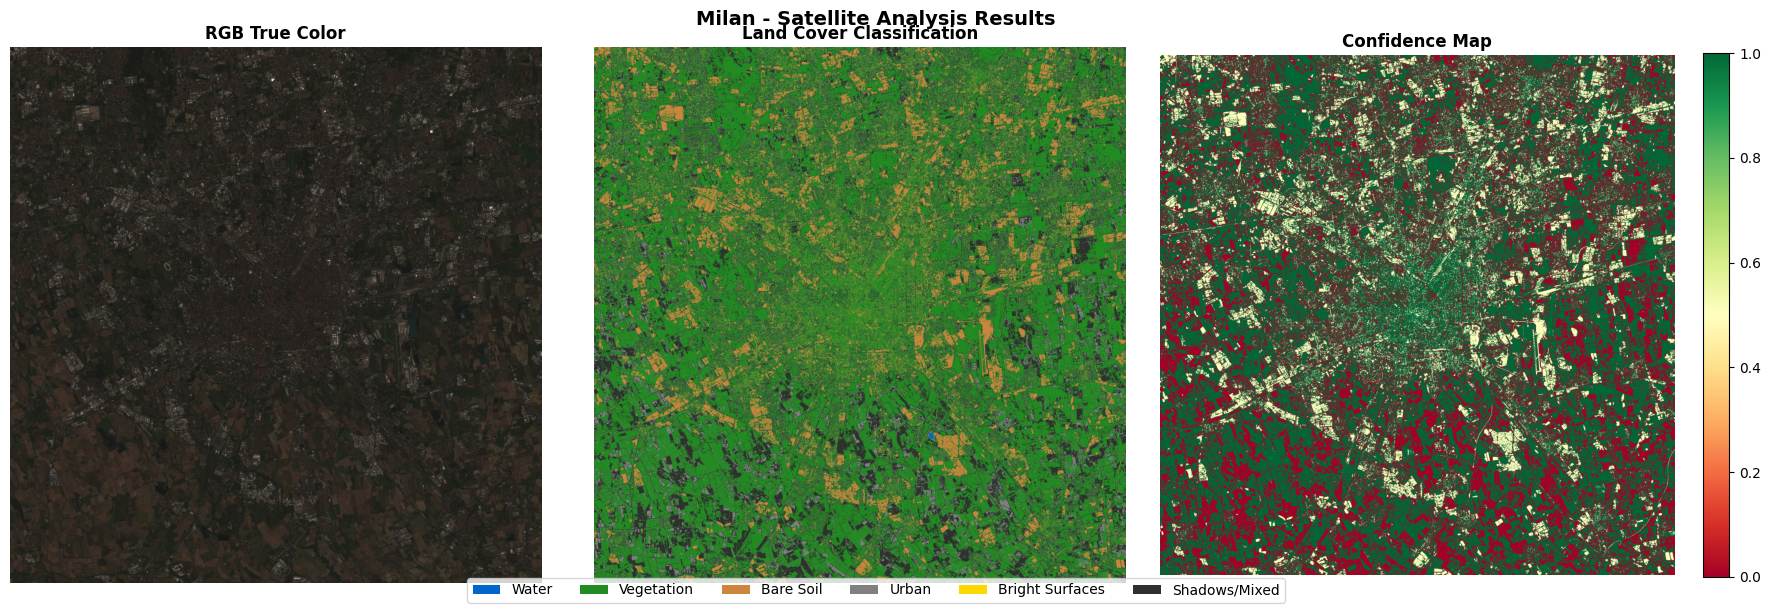

In [17]:
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# Create figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. RGB
axes[0].imshow(rgb)
axes[0].set_title('RGB True Color', fontsize=12, fontweight='bold')
axes[0].axis('off')

# 2. Classification
cmap = ListedColormap(class_colors)
axes[1].imshow(labels, cmap=cmap, vmin=0, vmax=5)
axes[1].set_title('Land Cover Classification', fontsize=12, fontweight='bold')
axes[1].axis('off')

# 3. Confidence
im = axes[2].imshow(confidence, cmap='RdYlGn', vmin=0, vmax=1)
axes[2].set_title('Confidence Map', fontsize=12, fontweight='bold')
axes[2].axis('off')
plt.colorbar(im, ax=axes[2], fraction=0.046)

# Legend
legend_elements = [Patch(facecolor=class_colors[i], label=class_names[i]) for i in range(6)]
fig.legend(handles=legend_elements, loc='lower center', ncol=6, fontsize=10, 
           bbox_to_anchor=(0.5, -0.02))

plt.suptitle(f'{CITY} - Satellite Analysis Results', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Step 6: Save Results (Optional)

In [18]:
# Save outputs
output_dir = data_dir.parent / "notebook_results"
output_dir.mkdir(exist_ok=True)

# Save classification image
fig, ax = plt.subplots(figsize=(12, 10))
ax.imshow(labels, cmap=cmap, vmin=0, vmax=5)
ax.axis('off')
legend_elements = [Patch(facecolor=class_colors[i], label=class_names[i]) for i in range(6)]
ax.legend(handles=legend_elements, loc='upper right', fontsize=9)
plt.savefig(output_dir / 'classification.png', dpi=150, bbox_inches='tight')
plt.close()

# Save labels as numpy array
np.save(output_dir / 'labels.npy', labels)
np.save(output_dir / 'confidence.npy', confidence)

print(f"✅ Results saved to: {output_dir}")
print(f"   - classification.png")
print(f"   - labels.npy")
print(f"   - confidence.npy")

✅ Results saved to: c:\TEMP_1\satellite_git_vt\satellite_git\data\processed\notebook_results
   - classification.png
   - labels.npy
   - confidence.npy


---

## 📥 Data Download Instructions

If you don't have satellite data yet:

### Option 1: Use the CLI script
```bash
python scripts/analyze_city.py --city Milan --method consensus
```

### Option 2: Manual download
1. Go to [Copernicus Browser](https://browser.dataspace.copernicus.eu/)
2. Search for Sentinel-2 L2A products over your city
3. Download a cloud-free image
4. Extract bands using:
   ```bash
   python scripts/extract_all_bands.py <downloaded.zip> data/cities/<city>/bands
   ```

---

**That's it!** 🎉

In [ ]:
import sys
sys.path.insert(0, '../src')

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import rasterio

# Our modules
from satellite_analysis.utils import AreaSelector
from satellite_analysis.analyzers.classification import ConsensusClassifier
from satellite_analysis.preprocessing.normalization import min_max_scale

print("✅ Setup complete!")

## Step 1: Select City

Choose a city to analyze. The system will find its coordinates automatically.

In [ ]:
# ========================================
# 👇 CHANGE THIS TO YOUR CITY
# ========================================
CITY = "Milan"
RADIUS_KM = 15
# ========================================

selector = AreaSelector()
bbox, info = selector.select_by_city(CITY, radius_km=RADIUS_KM)

print(f"🌍 City: {CITY}")
print(f"📍 Center: {info['center'][0]:.4f}°N, {info['center'][1]:.4f}°E")
print(f"📐 Radius: {RADIUS_KM} km")
print(f"📦 Bounding Box: {bbox}")

## Step 2: Load Satellite Data

Load the Sentinel-2 bands (B02=Blue, B03=Green, B04=Red, B08=NIR).

**Note:** You need to have the data downloaded first. If not available, see the "Data Download" section at the end.

In [ ]:
# Find data directory
possible_dirs = [
    Path(f"../data/cities/{CITY.lower()}/bands"),
    Path(f"../data/cities/{CITY.lower()}"),
    Path(f"../data/processed/{CITY.lower()}_centro"),
]

data_dir = None
for d in possible_dirs:
    if d.exists() and (d / "B02.tif").exists():
        data_dir = d
        break

if data_dir is None:
    print("❌ No data found! Please download data first (see last section)")
else:
    print(f"✅ Found data in: {data_dir}")

In [ ]:
# Load bands
bands = {}
for band_name in ['B02', 'B03', 'B04', 'B08']:
    with rasterio.open(data_dir / f"{band_name}.tif") as src:
        bands[band_name] = src.read(1)
        print(f"✅ {band_name}: {bands[band_name].shape}")

# Stack into array (H, W, 4)
stack = np.stack([bands['B02'], bands['B03'], bands['B04'], bands['B08']], axis=-1)
print(f"\n📊 Total: {stack.shape[0]:,} × {stack.shape[1]:,} pixels = {stack.shape[0]*stack.shape[1]:,} pixels")

## Step 3: Preview Image

Create an RGB preview to verify we have the right area.

In [ ]:
# Create RGB (Red=B04, Green=B03, Blue=B02)
rgb = stack[:, :, [2, 1, 0]].astype(np.float32)

# Normalize each channel
for i in range(3):
    channel = rgb[:, :, i]
    rgb[:, :, i] = (channel - channel.min()) / (channel.max() - channel.min() + 1e-10)

# Apply simple contrast enhancement
rgb = np.clip(rgb * 1.5, 0, 1)

plt.figure(figsize=(12, 10))
plt.imshow(rgb)
plt.title(f"{CITY} - RGB True Color", fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

print("👆 Verify this shows your city area correctly!")

## Step 4: Run Classification

Run the **Consensus Classifier** which combines:
- K-Means clustering (unsupervised)
- Spectral indices (rule-based)

This gives better results than either method alone.

In [ ]:
# Initialize classifier
classifier = ConsensusClassifier(
    n_clusters=6,
    confidence_threshold=0.5,
    random_state=42
)

# Band indices mapping
band_indices = {'B02': 0, 'B03': 1, 'B04': 2, 'B08': 3}

print("🔄 Running classification... (this takes ~30-60 seconds)")

# Run classification
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    labels, confidence, uncertainty, stats = classifier.classify(stack, band_indices)

print("\n✅ Classification complete!")
print(f"\n📊 Results:")
print(f"   Agreement: {stats['agreement_pct']:.1f}%")
print(f"   Confidence: {stats['avg_confidence']:.2f}")
print(f"   Uncertain: {stats['uncertain_pct']:.1f}%")

## Step 5: View Results

In [ ]:
# Class definitions
class_names = {
    0: 'Water',
    1: 'Vegetation', 
    2: 'Bare Soil',
    3: 'Urban',
    4: 'Bright Surfaces',
    5: 'Shadows/Mixed'
}

class_colors = [
    '#0066CC',  # Water - Blue
    '#228B22',  # Vegetation - Green
    '#CD853F',  # Bare Soil - Brown
    '#808080',  # Urban - Gray
    '#FFD700',  # Bright - Yellow
    '#2F2F2F'   # Shadows - Dark
]

# Print class distribution
print("📊 Land Cover Distribution:")
print("-" * 35)
for cls_name, info in stats['class_distribution'].items():
    bar = '█' * int(info['percentage'] / 2)
    print(f"{cls_name:<15} {info['percentage']:>5.1f}% {bar}")

In [ ]:
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# Create figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. RGB
axes[0].imshow(rgb)
axes[0].set_title('RGB True Color', fontsize=12, fontweight='bold')
axes[0].axis('off')

# 2. Classification
cmap = ListedColormap(class_colors)
axes[1].imshow(labels, cmap=cmap, vmin=0, vmax=5)
axes[1].set_title('Land Cover Classification', fontsize=12, fontweight='bold')
axes[1].axis('off')

# 3. Confidence
im = axes[2].imshow(confidence, cmap='RdYlGn', vmin=0, vmax=1)
axes[2].set_title('Confidence Map', fontsize=12, fontweight='bold')
axes[2].axis('off')
plt.colorbar(im, ax=axes[2], fraction=0.046)

# Legend
legend_elements = [Patch(facecolor=class_colors[i], label=class_names[i]) for i in range(6)]
fig.legend(handles=legend_elements, loc='lower center', ncol=6, fontsize=10, 
           bbox_to_anchor=(0.5, -0.02))

plt.suptitle(f'{CITY} - Satellite Analysis Results', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Step 6: Save Results (Optional)

In [ ]:
# Save outputs
output_dir = data_dir.parent / "notebook_results"
output_dir.mkdir(exist_ok=True)

# Save classification image
fig, ax = plt.subplots(figsize=(12, 10))
ax.imshow(labels, cmap=cmap, vmin=0, vmax=5)
ax.axis('off')
legend_elements = [Patch(facecolor=class_colors[i], label=class_names[i]) for i in range(6)]
ax.legend(handles=legend_elements, loc='upper right', fontsize=9)
plt.savefig(output_dir / 'classification.png', dpi=150, bbox_inches='tight')
plt.close()

# Save labels as numpy array
np.save(output_dir / 'labels.npy', labels)
np.save(output_dir / 'confidence.npy', confidence)

print(f"✅ Results saved to: {output_dir}")
print(f"   - classification.png")
print(f"   - labels.npy")
print(f"   - confidence.npy")

---

## 📥 Data Download Instructions

If you don't have satellite data yet:

### Option 1: Use the CLI script
```bash
python scripts/analyze_city.py --city Milan --method consensus
```

### Option 2: Manual download
1. Go to [Copernicus Browser](https://browser.dataspace.copernicus.eu/)
2. Search for Sentinel-2 L2A products over your city
3. Download a cloud-free image
4. Extract bands using:
   ```bash
   python scripts/extract_all_bands.py <downloaded.zip> data/cities/<city>/bands
   ```

---

**That's it!** 🎉